# Pool-based sampling

## Overview

In this example, the we apply an `ActiveLearner` onto the iris dataset using pool-based sampling. In this setting, we assume a small set of labeled data $\mathcal{L}$ and a large set of unlabeled data $\mathcal{U}$ such that $\left| \mathcal{L} \right| \ll \left| \mathcal{U} \right|$. In his review of the active learning literature, Settles covers a high-level overview of the general pool-based sampling algorithm:

> Queries are selectively drawn from the pool, which is usually assumed to be closed (i.e., static or non-changing), although this is not strictly necessary. Typically, instances are queried in a greedy fashion, according to an informativeness measure used to evaluate all instances in the pool (or, perhaps if $\mathcal{U}$ is very large, some subsample thereof).

Along with our pool-based sampling strategy, `modAL`'s modular design allows you to vary parameters surrounding the active learning process, including the core estimator and query strategy. In this example, we use `scikit-learn`'s [k-nearest neighbors classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as our estimator and default to `modAL`'s [uncertainty sampling](https://cosmic-cortex.github.io/modAL/Uncertainty-sampling) query strategy.

For further reading on pool-based sampling, we highly recommend the following resources:
- Burr Settles. [Active Learning Literature Survey](http://burrsettles.com/pub/settles.activelearning.pdf) [**Section 2.3: Pool-based Sampling**]. Computer Sciences Technical Report 1648, University of Wisconsin-Madison. 2009.

To enforce a reproducible result across runs, we set a random seed.

In [1]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

## The dataset

Now we load the dataset. In this example, we are going to use the famous Iris dataset. For more information on the iris dataset, see:
  - [The dataset documentation on Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
  - [The scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data'] 
y_raw = iris['target']

For visualization purposes, we apply PCA to the original dataset.

In [3]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

This is how the dataset looks like.

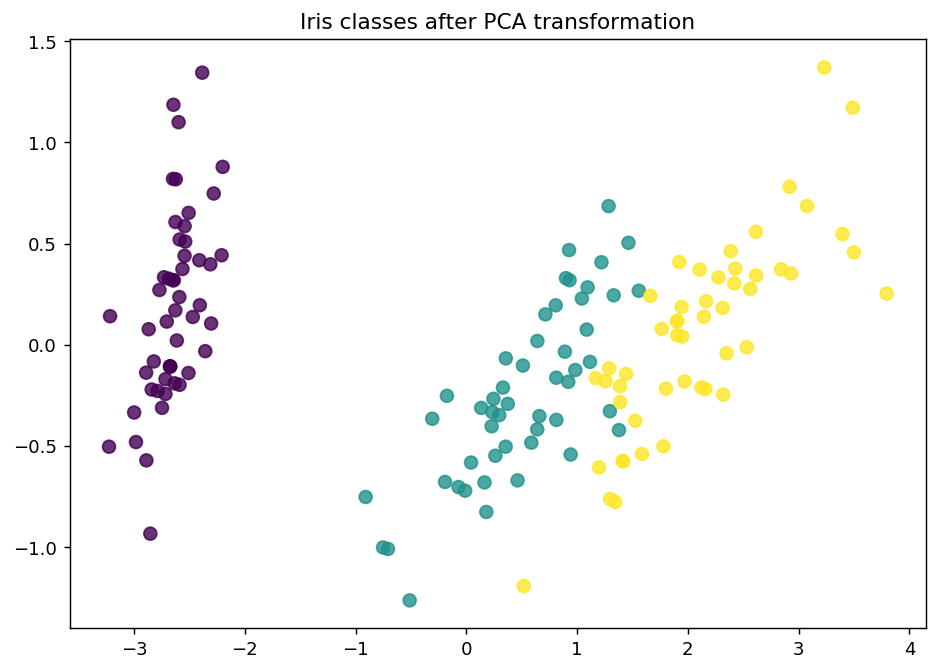

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our `iris` dataset into a training set $\mathcal{L}$ and $\mathcal{U}$. We first specify our training set $\mathcal{L}$ consisting of 3 random examples. The remaining examples go to our "unlabeled" pool $\mathcal{U}$.

In [5]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

## Active learning with pool-based sampling

For the classification, we are going to use a simple k-nearest neighbors classifier. In this step, we are also going to initialize the ```ActiveLearner```.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

Let's see how our classifier performs on the initial training set!

In [7]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

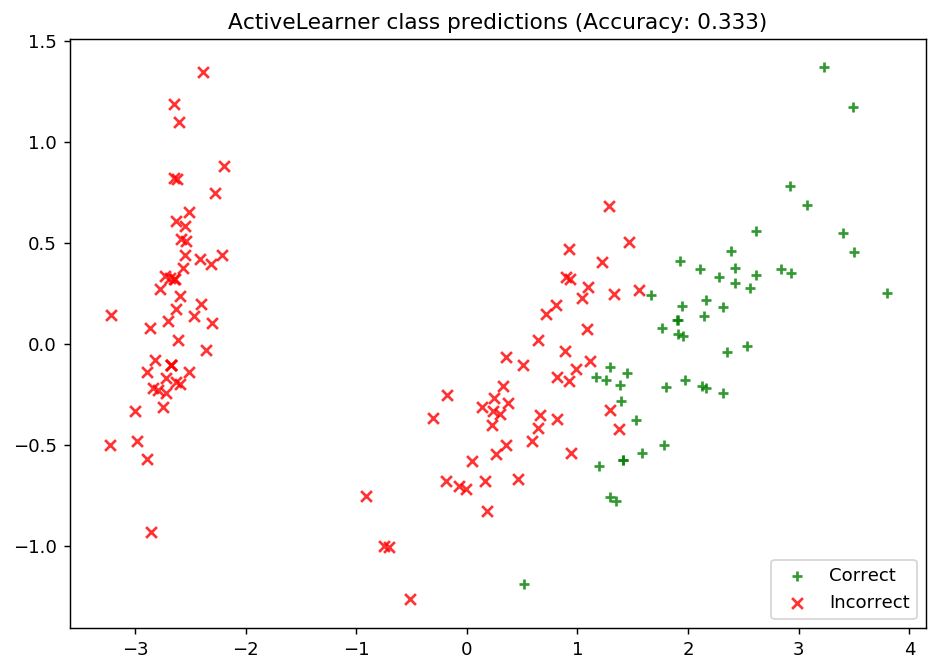

In [8]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

## Update our model by pool-based sampling our "unlabeled" dataset $\mathcal{U}$

As we can see, our model is unable to properly learn the underlying data distribution. All of its predictions are for the third class label, and as such it is only as competitive as defaulting its predictions to a single class – if only we had more data!

Below, we tune our classifier by allowing it to query 20 instances it hasn't seen before. Using uncertainty sampling, our classifier aims to reduce the amount of uncertainty in its predictions using a variety of measures — see the documentation for more on specific [classification uncertainty measures](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Uncertainty-sampling.html). With each requested query, we remove that record from our pool $\mathcal{U}$ and record our model's accuracy on the raw dataset.

In [9]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267


## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

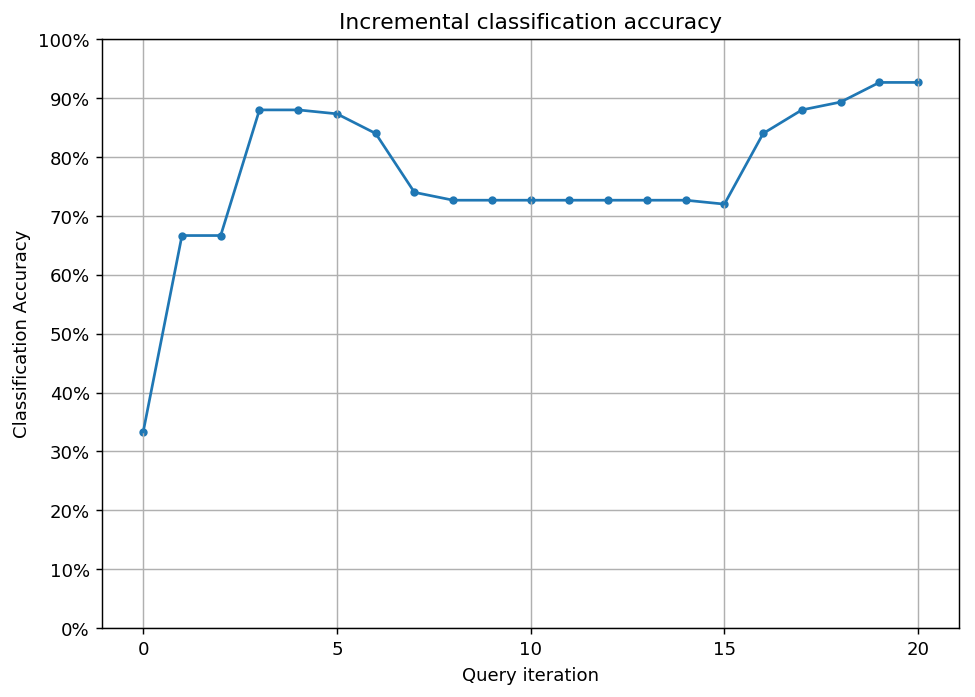

In [10]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

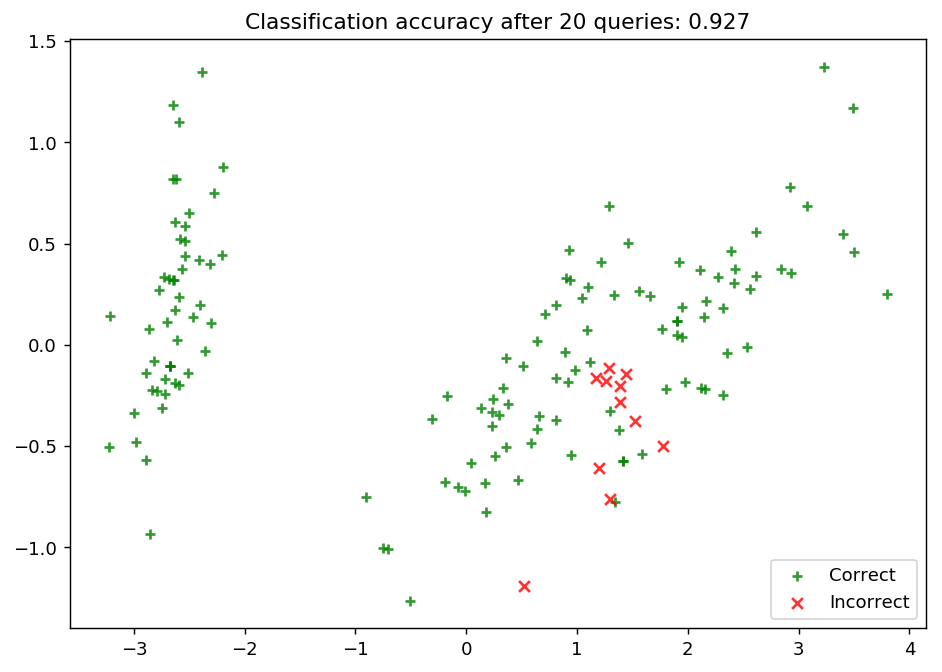

In [11]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()